# On the Suitability of RTT Measurements for Geolocation

rev. 1, 30 August 2017, [Brian Trammell](mailto: ietf@trammell.ch), Networked Systems Group, ETH Zürich

#### Abstract

It is widely understood in the network measurement community that round trip time measurements, whether passively derived by observation of transport-layer or application-layer signals linking packets in one direction to counterparts in another, or actively measured using a facility such as ICMP echo reply, are not on their own useful as input to trilateration for geolocation, as they are dominated by error terms which are not easy to remove. While details of previous attempts to correct for this error in order to use RTT measurements for certain geolocation tasks appear in the literature, there has not to date been an attempt to provide a empirical study of this error as guidance for applying RTT measurements for geolocation.

This work uses RTTs derived from RIPE Atlas Ping measurements to address this shortcoming. This dataset is especially useful in that we have presumptive ground truth for the locations of Atlas probes and a set of dedicated measurement targets, called Atlas anchors, which allows us to compare our RTT-derived estimated distances to actual distances, as well as to derive empirical models for a function deriving distance from observed RTT.

Assuming that our latency measurements are representative, our study shows that linear modeling of distance based on RTT is too imprecise for accurate distance measurement for trilateration, and that geolocation by exclusion requires sufficient datapoints of sufficiently low RTT and error that its applicability is largely a matter of luck. The availability of RTT data therefore presents negligible marginal geographic privacy risk to Internet-connected hosts.

#### About this notebook

This is a Jupyter notebook containing the analysis code used to generate its visualizations; it is, in a sense, a "runnable paper". It depends on the [dataprep](dataprep.ipynb) notebook in this directory to download measurements from RIPE Atlas and place them in distilled form in an HDF5 datastore, from which this paper reads data and generates visualizations and tables. If you don't have an HDF5 datastore locally, go run the [dataprep](dataprep.ipynb) notebook now, then come back here.

Run the following cell to set up the environment, import useful packages, define visualization functions, and load the dataframes from which this paper's analysis and visualization will follow:

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore") 

# Some constants
c = 299792458 # speed of light in meters per second
EARTH_RADIUS = 6371 # radius of Earth in kilometers
FIBER_REFRACTION = 1.4677 # assume Corning glass is typical

# Running figure numbering
_fignum = 0
def fignum(label):
    global _fignum
    _fignum += 1
    return "Figure {}: {}".format(_fignum, label)

# Some utilities
def ecdf(ser):
    ser = ser.sort_values()
    cdf = np.linspace(0.,1.,len(ser))
    return pd.Series(cdf, index=ser)

def plot_rtt_series(aid, pid): 
    """
    Given an anchor and probe ID, plot the time series of RTTs, 
    separately for IPv4 and IPv6.
    
    """

    example_ts_df = rtt_df[(rtt_df['aid'] == aid) & (rtt_df['pid'] == pid)].loc[:,['time','rtt','af']]

    example_ts_df_ip4 = example_ts_df[example_ts_df['af'] == 4]
    example_ts_df_ip6 = example_ts_df[example_ts_df['af'] == 6]
    plt.plot(example_ts_df_ip4['time'],example_ts_df_ip4['rtt'],".")

    plt.plot(example_ts_df_ip6['time'],example_ts_df_ip6['rtt'],".")

    plt.xlabel("time")
    plt.ylabel("RTT µs")
    plt.legend(labels=['ip4','ip6'])
    plt.title(fignum("RTT series for {} ({}) from probe {}".format(anchor_df.loc[aid]['name'], aid, pid)))

def _point_at_bearing(lon1, lat1, b, r):
    """
    Shoot a bearing at a given distance (in units of Earth radius) from a given long
    """
    lon1 = lon1 * math.pi / 180.0
    lat1 = lat1 * math.pi / 180.0 # convert to radians

    b = (b / 90) * math.pi / 2


    lat2 = math.asin(math.sin(lat1) * math.cos(r) + math.cos(lat1) * math.sin(r) * math.cos(b))
    lon2 = lon1 + math.atan2(math.sin(b) * math.sin(r) * math.cos(lat1), 
                             math.cos(r) - math.sin(lat1) * math.sin(lat2))
    
    lon2 = 180.0 * lon2 / math.pi
    lat2 = 180.0 * lat2 / math.pi

    return lon2, lat2

def _circle_with_radius(lon, lat, km):
    """
    Return lat/lon coordinate vectors of a circle 
    with a given radius in kilometers
    """
    latArray = []
    lonArray = []
    
    for bearing in range(0,360):
        lon2, lat2 = _point_at_bearing(lon, lat, bearing, km / EARTH_RADIUS)
        latArray.append(lat2)
        lonArray.append(lon2)
        
    return lonArray, latArray

def plot_exclusion_circles_for(aid, amin_df=None, pids=None, mapscale=None, whichkm='fiber_km'):
    # First, get a dataframe containing only the datapoints for the anchor and probes selected
    if amin_df is None:
        amin_df = min_df.loc[aid].loc[pids]
    
    # Now draw the basemap, scaled to fit most of the circles we'll draw
    if mapscale is None:
        mapscale = amin_df[whichkm].max() * 2500 
    alon = amin_df.iloc[0]['alon']
    alat = amin_df.iloc[0]['alat']
    plt.figure(figsize=(10,10))
    try:
        m = Basemap(width=mapscale,height=mapscale,
                    resolution='i',projection='laea',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    except ValueError:
        m = Basemap(resolution='c',projection='robin',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='#dddddd')
    m.drawmapboundary(fill_color='#dddddd')
    
    # Now plot circles
    for index, row in amin_df.iterrows():
        x, y = m(row['plon'],row['plat'])
        km = row[whichkm]
        if km > ( EARTH_RADIUS * math.pi ):
            continue
        clon, clat = _circle_with_radius(row['plon'], row['plat'], km)
        X, Y = m(clon, clat)
        plt.plot(X, Y, 'b-', alpha=0.33)
    
    # And plot a dot for the anchor
    x, y = m(alon, alat)
    plt.plot(x, y, "ro")
    
    # And title
    if len(amin_df) == 1:
        plt.title(fignum("Exclusion circle for probe {} around {}".format(amin_df.iloc[0].name, anchor_df.loc[aid]['name'])))
    else:
        plt.title(fignum("Exclusion circles for {} probes around {}".format(len(amin_df), anchor_df.loc[aid]['name'])))

def plot_exclusion_circles_by_rtt(aid, max_rtt=None, mapscale=None, whichkm = 'fiber_km'):
    # First, get a dataframe containing only the datapoints for the anchor
    amin_df = min_df.loc[aid]
    
    # Drop probes over max RTT
    if max_rtt is not None:
        amin_df = amin_df[amin_df['minrtt'] < max_rtt]
        # If max RTT leads to too few probes, drop it
        if len(amin_df) < 3:
            amin_df = min_df.loc[aid]

    plot_exclusion_circles_for(aid, amin_df=amin_df, mapscale=mapscale, whichkm=whichkm)

        
def plot_linfit_rtt_by_dist(plot_df, use_log=True, figsize=(12,8), label="all pairs", rtt_max=None):
    """
    Show a hexbin plot of correlating minumum RTT with ground truth distance 
    """
    plt.figure(figsize=figsize)
    x = plot_df['km']
    y = plot_df['minrtt']
    if use_log:
        plt.hexbin(x, y, cmap="Greys", bins="log")
    else:
        plt.hexbin(x, y, cmap="Greys")
    plt.colorbar()
    plt.xlabel("distance (km)")
    plt.ylabel("rtt (µs)")
    if rtt_max:
        plt.ylim(0,rtt_max)

    (slope, intercept, r, p, e) = scipy.stats.linregress(plot_df['km'],plot_df['minrtt'])
    plt.plot(x, slope * x + intercept)
    
    if use_log:
        scaletitle = "log10 count"
    else:
        scaletitle = "count"
    plt.title(fignum("RTT by distance for {0} ({1}, r-value {2:.2f})".format(label, scaletitle, r)))
    
    return (slope, intercept)

In [2]:
## Now load some data from the HDF store the dataprep notebook left us.
    
with pd.HDFStore('rtt.h5') as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    rtt_df = store['rtt_df']
    
min_df = pd.DataFrame({'minrtt': rtt_df.groupby(['aid','pid'])['rtt'].min(), 
                       'n':      rtt_df.groupby(['aid','pid'])['rtt'].count()})
loc_by_aid = anchor_df.loc[:,('lon','lat')]
loc_by_aid.columns = ['alon','alat']
loc_by_pid = probe_df.loc[:,('lon','lat')]
loc_by_pid.columns = ['plon','plat']
min_df = loc_by_pid.join(loc_by_aid.join(min_df, how="inner"), how="inner")

# calculate distance from probe/anchor locations reportsd in Atlas
min_df['tmp_aphi'] = (90.0 - min_df['alat']) * math.pi/180.0
min_df['tmp_pphi'] = (90.0 - min_df['plat']) * math.pi/180.0
min_df['tmp_atheta'] = min_df['alon'] * math.pi/180.0
min_df['tmp_ptheta'] = min_df['plon'] * math.pi/180.0
min_df['tmp_cos'] = ( np.sin(min_df['tmp_aphi']) * np.sin(min_df['tmp_pphi']) * 
                      np.cos(min_df['tmp_atheta'] - min_df['tmp_ptheta']) + 
                      np.cos(min_df['tmp_aphi']) * np.cos(min_df['tmp_pphi']) )
min_df['km'] = np.arccos(min_df['tmp_cos']) * EARTH_RADIUS
del min_df['tmp_aphi']
del min_df['tmp_pphi']
del min_df['tmp_atheta']
del min_df['tmp_ptheta']
del min_df['tmp_cos']

# determine lightspeed and fiber-assumption exclusion circle radii
min_df['c_km'] = (c / 1e9) * (min_df['minrtt'] / 2)
min_df['fiber_km'] = ((c / 1e9) / FIBER_REFRACTION) * (min_df['minrtt'] / 2)

## Introduction

In this work, we seek to answer the question "how useful is Internet end-to-end round-trip-time (RTT; also known as two-way delay) measurement to the problem of locating an endpoint with unknown location, given known location for other endpoint(s) it communicates with?"; or in the more negative sense, "how much risk does exposure of one's end-to-end RTT pose to the geographical privacy of a given endpoint?". We examine this question in two ways: by attempting to use RTT data as input for geolocation by [trilateration](https://en.wikipedia.org/wiki/Trilateration), and by attempting to localize by exclusion.

For trilateration, we must find a function of RTT that yields a distance:

$$ dist = f(RTT) $$

We first note that observable RTT is given by the equation:

$$ RTT_{obs} = \sum_{n=0}^f(D_{prop_{n \rightarrow n+1}} + D_{queue_n} + D_{proc_n}) + \sum_{m=0}^r(D_{prop_{m \rightarrow m+1}} + D_{queue_m} + D_{proc_m}) + D_{app} $$

In other words, for _f_ hops in the forward direction and _r_ hops in the reverse direction, the observed RTT is the sum of propagation, queueing, and processing delay at each hop, plus any delay at the far endpoint (here labeled as application delay). The idealized RTT for geolocation purposes, however, would be:

$$ RTT_{ideal} = \sum_{n=0}^f D_{prop_{n \rightarrow n+1}} + \sum_{m=0}^r D_{prop_{m \rightarrow m+1}} $$

This ideal situation only holds in the unlikely circumstance that sources of error (i.e., variable queueing delay, unmeasurable processing delay, and application delay) are zero:

$$ RTT_{obs} = RTT_{ideal} \iff RTT_{error} = \sum_{n=0}^f(D_{queue_n} + D_{proc_n}) + \sum_{m=0}^r(D_{queue_m} + D_{proc_m}) + D_{app} = 0 $$

Even this impossible, idealized situation would not yield us a perfect $dist = f(RTT)$, as the propagation delays themselves follow the paths of the optical fiber, copper wire, radio or optical wireless link carrying each hop, which do not follow straight lines, and each of which may have its own functions determining distance given delay. Nevertheless we will first look at the distribution of $RTT_{obs}$ versus known distances using the [RIPE Atlas](https://atlas.ripe.net) measurement network, in order to determine whether an $f(RTT)$ suitable for trilateration can be derived.

Failing that, the only thing we can say with complete certainty is that distance given an estimated one-way delay cannot be equal to or greater than the speed of light:

$$ dist_{lightspeed} < \frac{RTT_{obs}}{2} \times c $$

If we are willing to make an assumption that propagation delay is dominated by propagation through optical fiber, we can do a little better by slowing light by the refraction index of that fiber. Taking such an index from [a datasheet](http://ece466.groups.et.byu.net/notes/smf28.pdf) from a typical fiber at a typical wavelength, we arrive at:

$$ dist_{fiber} < \frac{RTT_{obs}}{2} \times \frac{c}{1.4677} $$

We turn our attention then to geolocation by exclusion: by taking RTT measurements from a set of vantage points with known locations, by determining the locations where an endpoint cannot be based on the inequality above for each vantage point, then taking the union of all those locations: the endpoint must therefore be somewhere within the area outside of those areas it cannot be. This is harder than it seems, because as we will see, the $dist_{fiber}$ equation above expresses the well-known network operations rule of thumb: every millisecond of RTT represents another 100km of distance. If one is lucky enough to have vantage points sufficiently near a target of interest with negligible standing congestion or overload conditions, where queueing and processing delay on the path are low and the total RTT is very low, then exclusion based geolocation is possible to national or regional level accuracy, but in general intersections of measurements additional vantage points add no additional reatriction. In any case, RTT-based geolocation by exclusion is far less usable or accurate than simple geolocation by looking up a source IP in a freely available national-level geolocation database.

### Related Work

The question addressed by this paper has been addressed recently, albeit indirectly: Cicalese et al <sup>1</sup> use active measurements of latency to discover anycast infrastructure in the Internet, using geolocation by exculsion from multiple vantage points to conclude that a target whose exclusion circles do not overlap must be multiply located; however, the technique proposed must revert to relatively complicated heuristics specific to infrastructure location in order to achieve city-level geolocation, and the specific question we posed here is only addressed in an initial description of the difficulty of the problem of processing latency data for exclusion and location. Our figure 5 agrees quite well with figure 2a in this work, showing the relative paucity of usable samples for exclusion-based geolocation.

Specifically addressing latency-based threats to privacy, Hopper et al <sup>2</sup> describe a latency-based attack on anonymizing systems, by correlating time series changes in latency in order to "fingerprint" circuits in an online anonymity network. The insights from this work, however, are not applicable to the generalized problem of latency-based geolocation in the Internet, since they require the stability of circuits as in a mixnet. 

We note that the problem of latency-based geolocation at layers 3/4 in the Internet is similar to that of layer 1 time-of-flight distance measurement and trilateration, but insights from recent impressive work in this space (e.g. Kotaru et al's SpotFi <sup>3</sup>) are not applicable to this problem, precisely because the $RTT_{error}$ term has a much higher magnitude in internetworks than on a single physical network.

- - - 

*References:* 

<sup>1</sup> "Latency-Based Anycast Geolocation: Algorithms, Software, and Data Sets" in IEEE JSAC 34(6), June 2016, [doi 10.1109/JSAC.2016.2558898](http://ieeexplore.ieee.org/document/7470242/).

<sup>2</sup> "How Much Anonymity does Network Latency Leak?" in ACM TISSEC 13(2), February 2010, doi [10.1145/1698750.1698753](http://doi.acm.org/10.1145/1698750.1698753).

<sup>3</sup> "SpotFi: Decimeter Level Localization using WiFi" in [ACM SIGCOMM 2015](http://conferences.sigcomm.org/sigcomm/2015/pdf/papers/p269.pdf).



## Methodology

### Data Source and Preparation

We use RTT data taken from the [RIPE Atlas](https://atlas.ripe.net) measurement network, selecting a set of 32 anchors from the more than 200 deployed; the list of selected anchors is shown in [the dataprep notebook](dataprep.ipynb#Anchor-Selection). We then find ping (ICMP echo request/reply) measurements targeted to each of these anchors, and consider round trip times from each of the 4007 probes used in these measurements. This yields a set of 13,780 distinct probe/anchor pairs: not every probe contacts every anchor, and vice-versa. We use this data set not only for its openness, but also since we have ground truth for the location of the anchors, and presumably low-error location estimates for the probes, whose locations are self-reported by their hosts.

In [3]:
# Get locations of anchors and probes in the dataset
aloc_df = min_df.groupby(level=[0]).first().loc[:,['alon','alat']]
ploc_df = min_df.groupby(level=[1]).first().loc[:,['plon','plat']]

In [4]:
# How many probes are there?
len(ploc_df)

4007

In [5]:
# And how many probe/anchor pairs?
len(min_df)

13780

The set of anchors and probes used in these anchoring measurements is plotted on the map below:

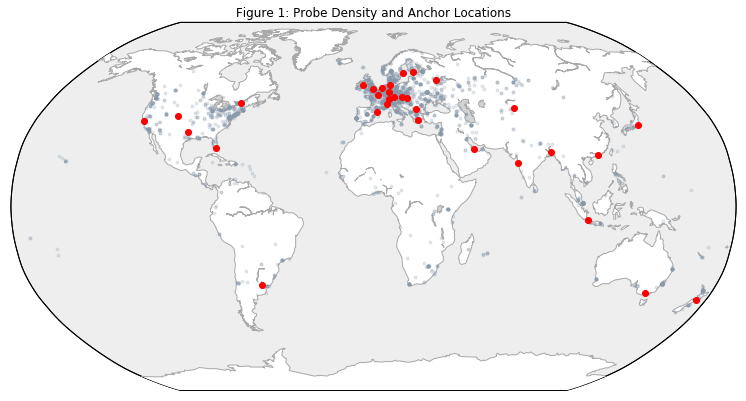

In [6]:
# Plot all anchors and probes on the world map
plt.figure(figsize=(13,10))
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines(color="darkgrey")
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawmapboundary(fill_color='#eeeeee')
plt.title(fignum("Probe Density and Anchor Locations"))
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,".",alpha=0.2,color="#8899aa")
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"ro")
plt.show()

Since the RIPE Atlas network is Europe-centric, we have more probes and anchors in Europe; the map below shows a Europe-centered view of the probes and anchors used:

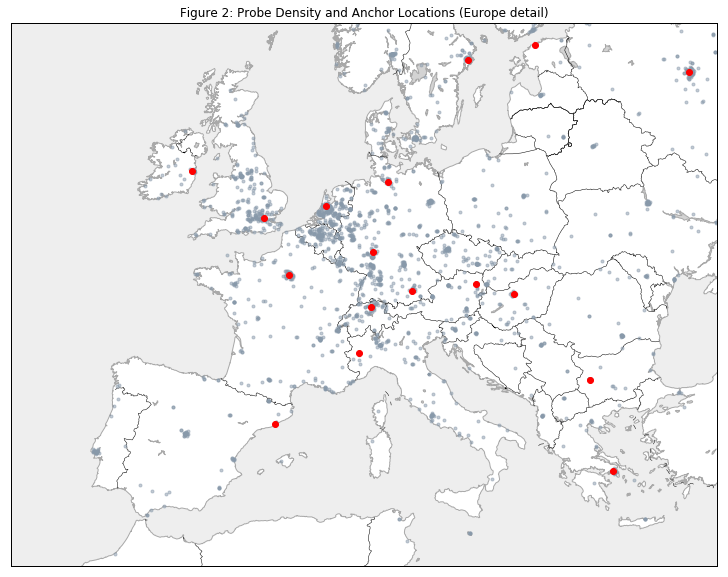

In [7]:
plt.figure(figsize=(13,10))
m = Basemap(width=3900000, height=3000000, projection='laea',lat_0=48,lon_0=8,resolution='i')
m.drawcoastlines(color="darkgrey")
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawcountries()
m.drawmapboundary(fill_color='#eeeeee')
plt.title(fignum("Probe Density and Anchor Locations (Europe detail)"))
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,".",alpha=0.5, color="#8899aa")
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"ro")
plt.show()

Since the terms in $RTT_{error}$ are more variable than those in $RTT_{ideal}$, we take a number of RTT measurements from each probe/anchor pair, and take the minimum from each pair. This reduces our set of 6,187,693 raw measurements to 13,780 minumum $RTT_{obs}$, one per anchor/probe pair. We have up to 540 samples per path (three samples per measurement, measurements taken every four minutes, via IPv4 and IPv6, for six hours).

In [8]:
# How many raw measurements do we have?
len(rtt_df)

6187693

## Results 


### Correlation between Distance and Minimum Delay

For each of our samples, we have probe and anchor latitude and longitude, from which we derive a spherical-approximated great circle distance. We can then see how well the minimum round-trip time sample for a given anchor/probe pair correlates with the actual distance. In an ideal situation (i.e., where $RTT_{min} = RTT_{ideal}$), this relationship is linear and governed by the speed of light, so we attempt a linear correlation in the figure below. Here, bins are colored on a log scale by the number of samples falling within them. Here we can see our dataset is biased toward short-distance, low-RTT samples, which is a consequence of the relative density of probes in anchors in Europe, which is small and well-connected. The blue line represents this linear fit.

Similarly, the orange line represents the circle of exclusion by the speed of light ($ dist < \frac{RTT_{obs}}{2} \times c $), and shows that the actual relationship between RTT and distance differs significantly from its theoretical bounds. One explanation for this feature is the predominance of optical fiber in long-haul Internet links, and the fact that the speed of light in optical fiber is determined by its index of refraction; we plot the circle of exclusion by the speed of light in fiber with the green line.




From these lines, we derive the following insights: the correlation between distance and RTT is relatively good $(r = 0.88)$, but not good enough to build a linear model as input to trilateration, which requires exact distance estimates from the vantage points to the unknown point to trilaterate. All data points lie above the green line, with some datapoints at certain distances dominated by point-to-point submarine fiber links (~2500 and ~6000 km) lying very close to this theoretical ideal, but with the bulk of the data points lying well above. The difference in slope between the linear fit and the fiber exclusion circle, and the y-intercept of the linear fit, are explained by the contribution of non-ideal terms to RTT: 

$$ RTT_{error} = \sum_{n=0}^f(D_{queue_n} + D_{proc_n}) + \sum_{m=0}^r(D_{queue_m} + D_{proc_m}) + D_{app} > 0 $$

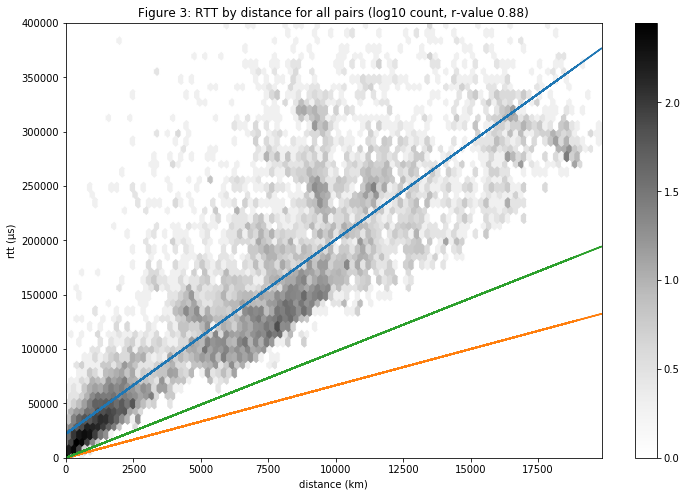

In [9]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df, rtt_max=400000)
plt.plot(min_df['km'], min_df['km'] * 2e9 / c)
plt.plot(min_df['km'], min_df['km'] * 2e9 * FIBER_REFRACTION / c)

### Relative Error in the Linear Model

This error term $RTT_{error}$ varies by anchor. The figure below shows the empirical cumulative distibution function of relative error in the linear model derived above on a per anchor basis (grey lines) and for the dataset as a whole (red line), and shows this variability.  For some anchors we have enough samples of sufficiently low RTT and  error that the median relative error is around 10%, while for others we have fewer nearby probes and therefore fewer good samples, such that median relative error is around 100%. The median relative error across the whole dataset is about 30%.

We conclude that the the linear model is not particularly useful as input for trilateration, and confirms that geolocation by exclusion is a more suitable approach.

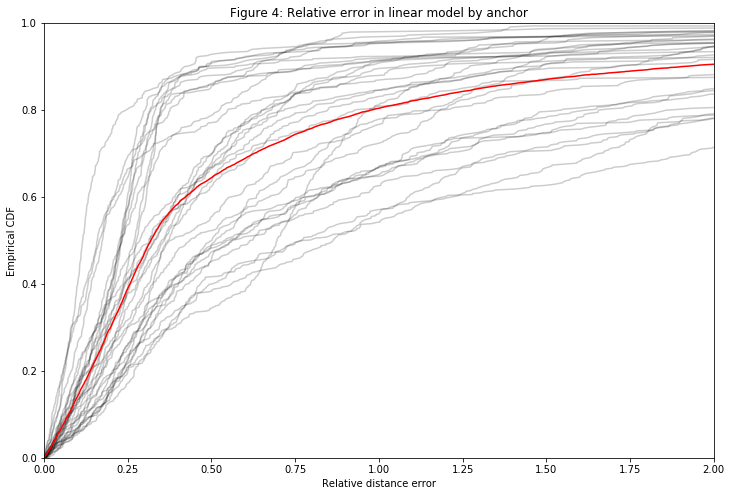

In [10]:
# derive estimated distance in kilometers from the model
min_df['lin_km'] = (min_df['minrtt'] - linb) / linm

# iterate over anchors to draw light grey lines
aid_list = min_df.index.levels[0].sort_values().values
plt.figure(figsize=(12,8))
for aid in aid_list:
    amin_df = min_df.loc[aid]
    plt.plot(ecdf(np.abs(amin_df['km'] - amin_df['lin_km']) / amin_df['km']), 'k', alpha=0.2)
plt.plot(ecdf(np.abs(min_df['km'] - min_df['lin_km']) / min_df['km']), 'r')
plt.xlim(0,2)
plt.ylim(0,1)
plt.xlabel("Relative distance error")
plt.ylabel("Empirical CDF")
plt.title(fignum("Relative error in linear model by anchor"))

### Radii of Exclusion Circles

We therefore turn our attention to the exclusion circles we can derive from our RTT measurements. Here we use the more optimistic assumption that we can use the speed of light in fiber to calculate these circles. The results are shown in the figure below, with empirical CDFs per anchor (grey lines) and across the whole dataset (red line). Here we see even more variability per anchor, based on the availibility of nearby, low-additional-delay probes. Our median exclusion circle across the whole dataset has a radius of about 2500km, which can localize to a continent; seven anchors are remote enough that their median sample is non-exclusionary, i.e. larger than the surface of the Earth.

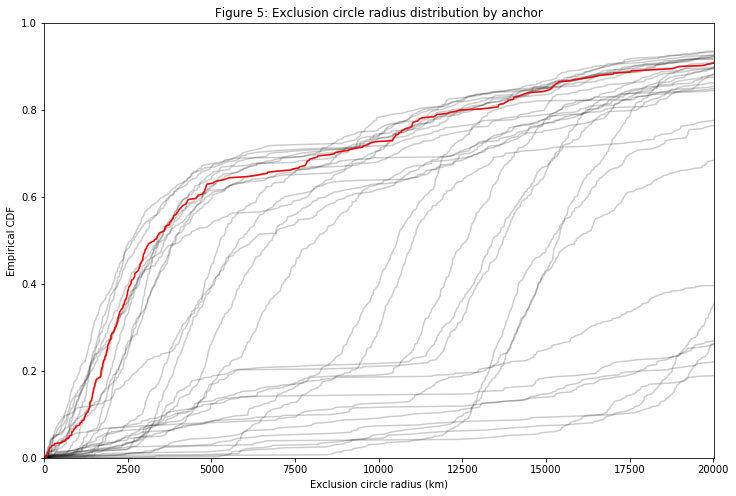

In [11]:
# iterate over anchors to draw light grey lines
aid_list = min_df.index.levels[0].sort_values().values
plt.figure(figsize=(12,8))
for aid in aid_list:
    amin_df = min_df.loc[aid]
    plt.plot(ecdf(amin_df['fiber_km']), 'k', alpha=0.2)
plt.plot(ecdf(amin_df['fiber_km']), 'r')
plt.xlim(0, math.pi * EARTH_RADIUS)
plt.ylim(0,1)
plt.xlabel("Exclusion circle radius (km)")
plt.ylabel("Empirical CDF")
plt.title(fignum("Exclusion circle radius distribution by anchor"))

### Illustration of RTT dynamics

Our data set includes a variety of RTT dynamic behaviors which illustrate the need to reduce the dataset by taking the minumum RTT for each probe/anchor pair present, as well as illustrating the utility of time-series latency measurements for other purposes. In the best case, RTTs are low, with low variance, and no major difference across address family, as shown in this measurement series of the Melbourne anchor from probe [6230](https://atlas.ripe.net/probes/6230/) in New Zealand:

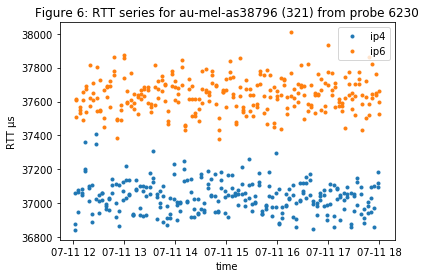

In [12]:
plot_rtt_series(321, 6230)

This measurement series is relatively useful for exclusion-based geolocation, given its low RTT: based on this information, the Melbourne anchor must be in eastern Australia, New Zealand, or on a nearby South Pacific island, as shown in the figure below:

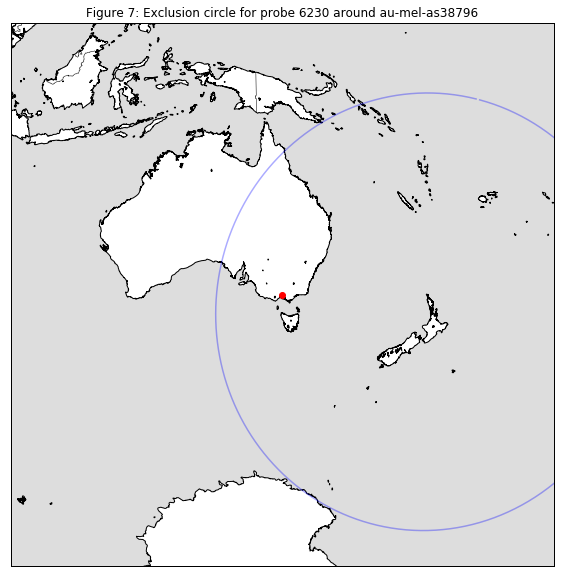

In [13]:
plot_exclusion_circles_for(321, pids=[6230], whichkm="fiber_km")

Some pairs show relatively low variability, but better performance using one address family as opposed to another; the Atlas anchor in Sofia, for example, is 11% faster via IPv6 than via IPv4 from probe [6072](https://atlas.ripe.net/probes/6072/):

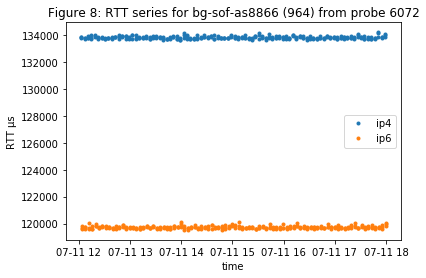

In [14]:
plot_rtt_series(964, 6072)

The RTT time series can also be quite discontinuous: here, the IPv4 route between probe [21995](https://atlas.ripe.net/probes/6072/) and the anchor in Dacca changed during the measurement, and latency increased significantly. Note also that the new path shows far more latency variability than the old one, indicating congestion or load on the new path. It is precisely this sort of dynamic which is useful for detection and diagnostics in network operations.

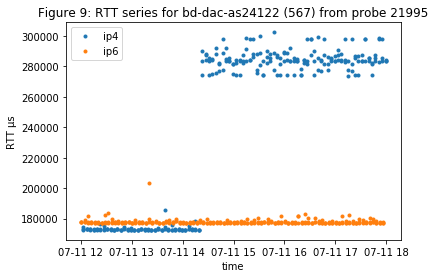

In [15]:
plot_rtt_series(567, 21995)

Neither of these latter examples are very useful for exclusion-based geolocation, though: the latencies are too high. Even making the assumption that we can rely on the stricter speed-of-light-in-fiber for our exclusion cirles, this last example can only conclusively state that the Bangladesh anchor is not in New Zealand, as shown in the figure below.

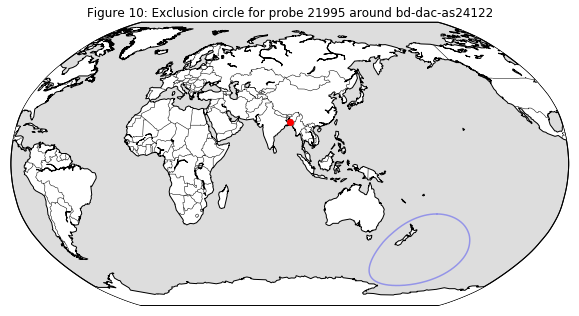

In [16]:
plot_exclusion_circles_for(567, pids=[21995], whichkm="fiber_km")

### Examples of Geolocation by Exclusion

In the figures below, we show a few examples of geolocation by exclusion. Note that in most of these cases, a single vantage point very close to the target provides most or all of the certainty about the location of the target, underlining the point that exclusion is a usable technique for geolocation only if one is lucky enough to be close by. This is thorougly unsurprising, as each additional 10µs of RTT represents an additional kilometer exclusion circle radius at fiber speed.

We first look at a couple of best-case examples, concerning European anchors and probes. First, we consider RIPE's anchor in the Netherlands, which is surrounded with probes, unsurprising given RIPE's Amsterdam location and the organic growth of the probe infrastructure along the social networks of networking geeks: 93 probes report an RTT of less than 10 milliseconds to this anchor, but only two of them can conclusively exclude the anchor from locations outside the Netherlands. One of these ([6001](https://atlas.ripe.net/probes/6001)) is located on the same machine, and the other ([6137](https://atlas.ripe.net/probes/6137)) is also operated by RIPE and is in the same network. Most of the rest of these samples can only localize the anchor to Benelux or Northern Europe; i.e., less precise information than is available from country-level geolocation of source IP addresses.

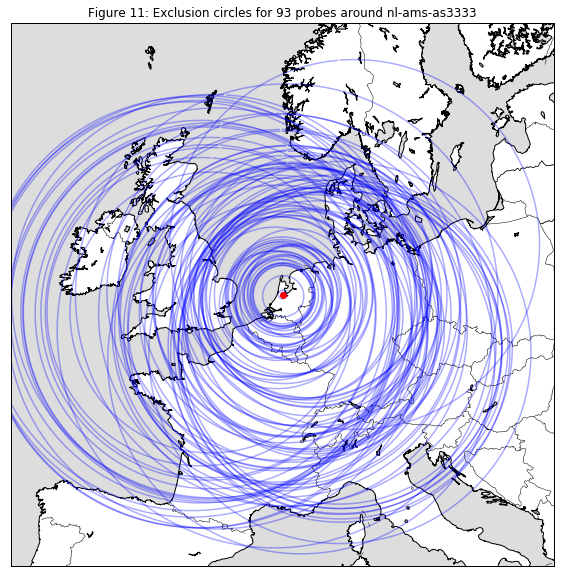

In [17]:
plot_exclusion_circles_by_rtt(12,10000)


The Torino anchor is still well-connected, but surrounded with less of an embarassment of riches of vantage points: only 8 are within 10ms. Here we see that only two probes (both in Torino, one running on the same machine) have sufficient information to restrict the anchor's location to northern Italy. The rest of these probes can only restrict the location to Europe.


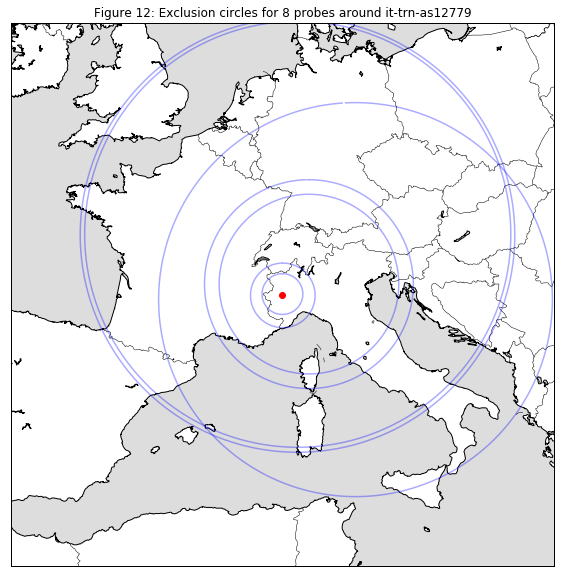

In [18]:
plot_exclusion_circles_by_rtt(4,10000)

The Buenos Aires anchor presents a more globally typical example: here ten probes within 50ms can localize the anchor to continent-level accuracy; the nearest probe, in Montevideo, is capable of restricting the probe to northern Argentina, Paraguay, Uruguay, or southern Brazil. 

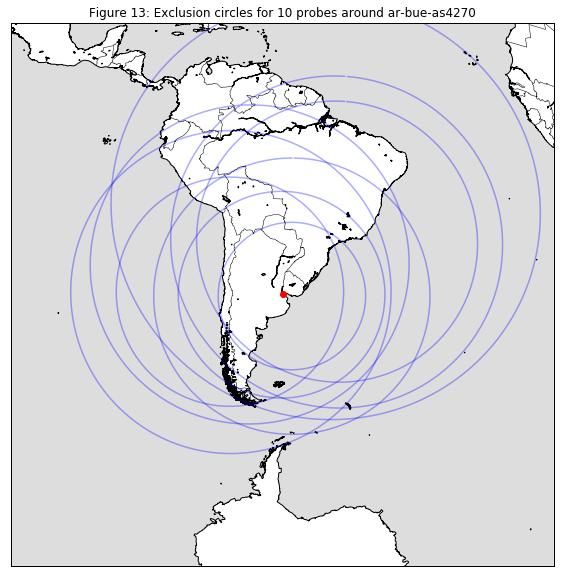

In [19]:
plot_exclusion_circles_by_rtt(669,50000)

## Conclusions

Based on our exploration of a large, actively-measured RTT measurement dataset with ground truth about the locations of both endpoints, we have derived a linear model relating RTT to distance, albeit with too much error to reliably use for trilateration, and shown that typical latencies in the Internet make the use of exclusion-based geolocation largely a matter of luck: vantage points within a few milliseconds of a target to geolocate may be able to get better than national-level location information, but in the common case using RTT for geolocation is less accurate than IP address based approaches. 

We therefore conclude that the marginal geographic privacy risk associated with making RTT information available to a party that already has access to IP address information about a target to geolocate is negligable.